<a href="https://colab.research.google.com/github/fezilemahlangu/Natural-Language-Processing-Project/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fezile Mahlangu 

#2089676

#NLP Project 2022 


---

Project: Spam Classification Using Naive Bayes

Aim: Train and optimize a spam classifier using Naive Bayes classification model

Tasks:
- [x] Implement a Naive Bayes Model
- [x] Investigate the effect of using different features 
- [x] Evaluate the performance of different models
- [x] Optimize the model for better performance






---



# Imports

In [99]:
import numpy as np
import pandas as pd
import nltk
import copy
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
nltk.download("wordnet")
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
nltk.download('omw-1.4')

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix,f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Loading data

In [2]:
#loading data -> Remember to remove drive path and use normal path

train_df = pd.read_csv("/content/drive/MyDrive/NLP/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/NLP/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NLP/test.csv")
display(train_df)

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1
...,...,...
3097,Subject: \r\n( envelope - from 20040929124340 ...,1
3098,Subject: re : intraday eastrans nomination cha...,0
3099,Subject: meter 1601\r\ndaren - meter 1601 has ...,0
3100,Subject: need legal help ?\r\nto unsubscribe f...,1


Text(0, 0.5, 'number of records')

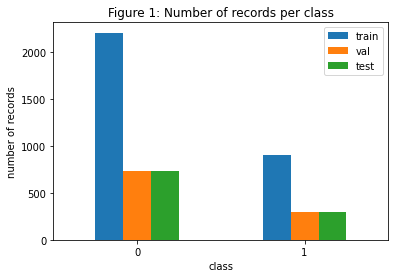

In [100]:

train = [train_df[train_df.label==0].count()[0],train_df[train_df.label==1].count()[0]]
test = [test_df[test_df.label==0].count()[0],test_df[test_df.label==1].count()[0]]
val = [val_df[val_df.label==0].count()[0],val_df[val_df.label==1].count()[0]]

index = ['0', '1']
df = pd.DataFrame({'train': train,
                   'val': val, 'test':test}, index=index)
ax = df.plot.bar(rot=0,title="Figure 1: Number of records per class")
ax.set_xlabel("class")
ax.set_ylabel("number of records")


# 1. Preprocessing of data

The text will be tokenized and there will be a list of words for each sentence 

In [4]:
train_df.head()

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1


In [5]:
#creating x and y arrays from dataframes 
train_x = train_df.text
train_y = train_df.label

test_x = test_df.text
test_y = test_df.label

val_x = val_df.text
val_y = val_df.label

len(train_x)


3102

In [6]:
#turn into np arrays 
train_y = np.array(train_y)
val_y = np.array(val_y)
test_y = np.array(test_y)

In [7]:
def split_row(row):
  """
  Function takes in a row and splits by "\n"
  """
  return row.split("\n")

In [8]:
def tokenize(row):
  """
  splits by white space and punctuations
  """
  return wordpunct_tokenize(row)

In [9]:
def handle_money(row):
  #puts $5.99 back from ["$","5",".","99"]
  leng = len(row)
  i = 0
  while leng != 0 :
    if row[i]=='$' and row[i+2].isnumeric():
      row = row[:i+1] + row[(i+2):]
      leng-=1

    elif (row[i] == '.' and row[i+2].isnumeric() and row[i-2].isnumeric()):
      row = row[0:i-1] + row[i:i+1] + row[i+2:]
      leng-=2
    i+=1
    leng-=1

  return row
  

In [10]:
def remove_punct(row):
  """
  Goes through row and removes punctuation marks
  """

  return [word for word in row if word.isalpha()] 


In [11]:
stemmer = nltk.stem.porter.PorterStemmer()
def stem_words(row):
  """
  Function that performs stemming 
  removes word ending crudely -ing 
  """
  
  return [stemmer.stem(i) for i in row]


In [12]:
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
def lemmatize(row):
  """
  performs lemmatization 
  make a word a root 
  """
 
  return [lemmatizer.lemmatize(i) for i in row]

In [13]:
#checking if functions work:

a = ["getting", "google", "meeting","rocks"]
print(a)
print(f"Stemming:{stem_words(a)}")
print(f"Lemmatization:{lemmatize(a)}")


['getting', 'google', 'meeting', 'rocks']
Stemming:['get', 'googl', 'meet', 'rock']
Lemmatization:['getting', 'google', 'meeting', 'rock']


In [14]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenize_with_money(row):
  '''
  splits by white space but doesnt split on money $
  '''
  return tokenizer.tokenize(row)


In [15]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(row):
  """
  Function that removes stop words -> really frequent words
  """
  return [i for i in row if i not in stop_words]

In [16]:
def clean_x(data):
  clean = []
  for i in data:
    text = tokenize_with_money(i)

    text = remove_punct(text)

    text = remove_stop_words(text)

    text = stem_words(text)

    text = lemmatize(text)

    clean.append(text)
  return clean 



In [17]:

clean_train_x = clean_x(train_x)
clean_val_x = clean_x(val_x)
clean_test_x = clean_x(test_x)


In [18]:
print("Text before preprocessing: \n")
print(train_x[0])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Text after preprocessing: \n")
print(clean_train_x[0])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Text before preprocessing: 

Subject: thank you
ami and daren , , , ,
just wanted again to say thanks ! ! ! , for the great time at st . pete ' s beach ,
fla .
the company , food , fishing and yes , of coarse
the drink or many drinks were great ! ! ! daren , can relate to the drinks .
i enjoyed meeting everyone there .
we appreciate your business and look forward to continue our business relation
with enron in the future .
sincerely ,
tim
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text after preprocessing: 

['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
---------------------

In [19]:
print("Text before preprocessing: \n")
print(train_x[1])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Text after preprocessing: \n")
print(clean_train_x[2])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Text before preprocessing: 

Subject: spot or firm tickets
vance ,
the following nominations do not have deal tickets in sitara for september ,
2000 activity . please advise whether the deals will be spot or firm . daren
wants everything in sitara by 3 pm on monday , august 28 . thanks .
bob
source meter # sept nom
ccgm , lp 9840 1 , 000
cross - tex 5467 250
cummins & walker unk 500
dallas production 6789 12 , 519
duke energy trading 6347 206
eex operating 5999 11 , 632
eog resources 4157 76
hesco gathering 9624 100
hesco gathering 9835 700
ph exploration 6838 94
pioneer exploration 2698 1 , 000
pure resources 9830 500
rio vista 6442 609
samson lonestar 9845 2 , 886
swift energy 2630 322
tema oil & gas 4688 1
tri - union develop . 2697 700
whiting petroleum 6523 100
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text after preprocessing: 

['subject', 'softwar', 'micr

# 2. Training a standard Naive Bayes model 

In [22]:
from sklearn.pipeline import Pipeline
#creating a pipeline for each model 

pipeline1 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline2 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline3 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline4 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline4 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

pipeline5 = Pipeline([
   ('bow',CountVectorizer()),
    ('classifier',MultinomialNB()),
])

In [21]:
# #scale data ?

# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()

# x_train is after count_vector.fit 
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

#LAPLACE SMOOTHING 

In [23]:
clean_train_x_join = [" ".join(i) for i in clean_train_x] #turn to string for count_vector 
Model1 = pipeline1.fit(clean_train_x_join,train_y)



## 3a. Naive Bayes model using 10 most frequent words as features 

We will use the Counter function to find the 10 most frequent words. In order to do this we first need to need an array that will contains all the words found in our training data (after cleaning). We will however not include the word "subject" found in the subject line as to not bias the word "subject" that may be found in the email body. 

In [24]:
#creating one big array from clean_train_x
all_clean_x = []
for arr in clean_train_x:
  for i in range(1,len(arr)): #doesnt include "subject" from subject line
      all_clean_x.append(arr[i])

In [25]:
print(all_clean_x[0:50]) #doesnt inlcude subject

['thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea']


In [26]:
#get top 10 features using Counter 
Counter = Counter(all_clean_x)

top10 = Counter.most_common(10)

print("The top 10 features are:")
print(top10)
  
# print(most_occur)

The top 10 features are:
[('ect', 8343), ('hou', 4376), ('enron', 3908), ('com', 2452), ('deal', 2200), ('plea', 1892), ('ga', 1794), ('subject', 1674), ('meter', 1569), ('hpl', 1404)]


In [27]:
#extracting words from "top10" given by Counter.most_common
top_10_dictionary=[]
for i in top10:
  top_10_dictionary.append(i[0])
print(top_10_dictionary)


['ect', 'hou', 'enron', 'com', 'deal', 'plea', 'ga', 'subject', 'meter', 'hpl']


Since the features of a Naive bayes model is the vocabulary, we will remove words in the training data that are not the 10 most frequent words and fit the MultinomialNB using that corpus. 


In [28]:
top10_train_x = []
# top10_train_x[0]
for arr in clean_train_x:
  new_arr = []
  for word in arr:
    if word in top_10_dictionary:
      new_arr.append(word)
  top10_train_x.append(new_arr)




In [29]:
try:
  len(clean_train_x) == len(top10_train_x)
except:
  print("lengths do not match ")

In [30]:
print("First element clean:")
print(clean_train_x[0])
print("First element with top 10 features:")
print(top10_train_x[0])
print("--------------------------------------------------------------------")
print("Second element clean:")
print(clean_train_x[1])
print("Second element with top 10 features:")
print(top10_train_x[1])
print("--------------------------------------------------------------------")
print("Third element clean:")
print(clean_train_x[2])
print("Third element with top 10 features:")
print(top10_train_x[2])

First element clean:
['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
First element with top 10 features:
['subject', 'enron']
--------------------------------------------------------------------
Second element clean:
['subject', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea', 'advis', 'whether', 'deal', 'spot', 'firm', 'daren', 'want', 'everyth', 'sitara', 'pm', 'monday', 'august', 'thank', 'bob', 'sourc', 'meter', 'sept', 'nom', 'ccgm', 'lp', 'cross', 'tex', 'cummin', 'walker', 'unk', 'dalla', 'product', 'duke', 'energi', 'trade', 'eex', 'oper', 'eog', 'resourc', 'hesco', 'gather', 'hesco', 'gather', 'ph', 'explor', 'pioneer', 'explor', 

In [32]:
top10_train_x_join = [" ".join(i) for i in top10_train_x] #turn to string for count_vector 
Model2 = pipeline2.fit(top10_train_x_join,train_y) #fit 

## 3b. Naive Bayes model using 100 most frequent words as features 

In [33]:


# Counter = Counter(all_clean_x)

top100 = Counter.most_common(100)

print("The top 100 features are:")
print(top100)

top_100_dictionary=[]
for i in top100:
  top_100_dictionary.append(i[0])
print(top_100_dictionary)

The top 100 features are:
[('ect', 8343), ('hou', 4376), ('enron', 3908), ('com', 2452), ('deal', 2200), ('plea', 1892), ('ga', 1794), ('subject', 1674), ('meter', 1569), ('hpl', 1404), ('cc', 1392), ('thank', 1348), ('pm', 1331), ('need', 1249), ('e', 1203), ('daren', 1120), ('forward', 1091), ('price', 1089), ('volum', 1040), ('corp', 1030), ('know', 976), ('day', 950), ('new', 898), ('get', 892), ('compani', 873), ('j', 813), ('may', 806), ('mmbtu', 802), ('product', 800), ('chang', 788), ('see', 771), ('u', 766), ('l', 763), ('http', 756), ('contract', 751), ('inform', 737), ('attach', 713), ('let', 692), ('nom', 676), ('time', 673), ('farmer', 665), ('xl', 658), ('month', 653), ('would', 641), ('sale', 639), ('nomin', 632), ('messag', 618), ('mail', 607), ('one', 603), ('th', 594), ('call', 578), ('flow', 572), ('juli', 571), ('follow', 563), ('use', 561), ('robert', 556), ('question', 551), ('email', 517), ('ticket', 516), ('file', 515), ('net', 515), ('p', 512), ('report', 503),

In [34]:
top100_train_x = []
# top10_train_x[0]
for arr in clean_train_x:
  new_arr = []
  for word in arr:
    if word in top_100_dictionary:
      new_arr.append(word)
  top100_train_x.append(new_arr)

In [35]:
try:
  len(clean_train_x) == len(top100_train_x)
except:
  print("lengths do not match ")

In [36]:
print("First element clean:")
print(clean_train_x[0])
print("First element with top 100 features:")
print(top100_train_x[0])
print("--------------------------------------------------------------------")
print("Second element clean:")
print(clean_train_x[1])
print("Second element with top 100 features:")
print(top100_train_x[1])
print("--------------------------------------------------------------------")
print("Third element clean:")
print(clean_train_x[2])
print("Third element with top 100 features:")
print(top100_train_x[2])

First element clean:
['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
First element with top 100 features:
['subject', 'thank', 'daren', 'want', 'thank', 'time', 'compani', 'daren', 'busi', 'look', 'forward', 'busi', 'enron']
--------------------------------------------------------------------
Second element clean:
['subject', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea', 'advis', 'whether', 'deal', 'spot', 'firm', 'daren', 'want', 'everyth', 'sitara', 'pm', 'monday', 'august', 'thank', 'bob', 'sourc', 'meter', 'sept', 'nom', 'ccgm', 'lp', 'cross', 'tex', 'cummin', 'walker', 'unk', 'dalla', 'product', 'duke', 'energi', 'trade', 'eex', 'o

In [38]:
top100_train_x_join = [" ".join(i) for i in top100_train_x] #turn to string for count_vector 
Model3 = pipeline3.fit(top100_train_x_join,train_y) #fit

## 3c. Naive Bayes model removing 100 most frequent words from features 

In [39]:
not_top100_train_x = []

for arr in clean_train_x:
  new_arr = []
  for word in arr:
    if word not in top_100_dictionary:
      new_arr.append(word)
  not_top100_train_x.append(new_arr)

In [40]:
try:
  len(clean_train_x) == len(not_top100_train_x)
except:
  print("lengths do not match ")

print("First element clean:")
print(clean_train_x[0])
print("First element with top 100 features removed:")
print(not_top100_train_x[0])
print("--------------------------------------------------------------------")
print("Second element clean:")
print(clean_train_x[1])
print("Second element with top 100 features removed:")
print(not_top100_train_x[1])
print("--------------------------------------------------------------------")
print("Third element clean:")
print(clean_train_x[2])
print("Third element with top 100 features removed:")
print(not_top100_train_x[2])

First element clean:
['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
First element with top 100 features removed:
['ami', 'say', 'great', 'st', 'pete', 'beach', 'fla', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'continu', 'relat', 'futur', 'sincer', 'tim']
--------------------------------------------------------------------
Second element clean:
['subject', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea', 'advis', 'whether', 'deal', 'spot', 'firm', 'daren', 'want', 'everyth', 'sitara', 'pm', 'monday', 'august', 'thank', 'bob', 'sourc', 'meter', 'sept', 'nom', '

In [42]:
not_top100_train_x_join = [" ".join(i) for i in not_top100_train_x] #turn to string for count_vector 
Model4 = pipeline4.fit(not_top100_train_x_join,train_y) #fit 

## 3d. Naive Bayes model using subject line as the feature set

The subject line ends after "\r\n" thus we will split the subject from the body of the email using this. Since "Subject: " is found in every subject line, we will remove it and replace it with "" 

In [43]:
def get_subject(data):
  '''
  extracts subject line from each email 
  '''
  subject = data[0:data.find('\r\n')]
  return subject.replace("Subject: ","")

In [44]:
train_df.head()

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1


In [45]:
train_df["subject"] = train_df["text"].apply(lambda x: get_subject(x))
train_df.head()

,text,label,subject
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0,thank you
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0,spot or firm tickets
2,Subject: software\r\nmicrosoft windows xp prof...,1,software
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0,noms / actual flow for 2 / 27
4,Subject: superb so . ftware\r\nyoull discover ...,1,superb so . ftware


In [46]:
train_x_subject = train_df.subject
clean_train_x_subject = clean_x(train_x_subject)

In [48]:
clean_train_x_subject_join = [" ".join(i) for i in clean_train_x_subject] #turn to string for count_vector 
Model5 = pipeline5.fit(clean_train_x_subject_join,train_y) #fit



---



---


# 4. Evaluation using validation set

## 4a. Calculating the evaluation metrics

The metrics that will be used are : model accuracy, f1 score, precision, recall 

In [49]:
# count_vector = CountVectorizer()

clean_val_x_join = [" ".join(i) for i in clean_val_x] #turn to string for count_vector 

# trans_x = count_vector.fit_transform(clean_val_x_join)

# val_x_dense = np.array(trans_x.todense())


In [91]:
def get_accuracy(Model,x,y):
  predicted = Model.predict(x)
  return accuracy_score(y,predicted)

def get_f1_score(Model,x,y):
  predicted = Model.predict(x)
  return f1_score(y,predicted)

def get_precision(Model,x,y):
  predicted = Model.predict(x)
  return precision_recall_fscore_support(y,predicted,average="binary")[0]

def get_recall(Model,x,y):
  predicted = Model.predict(x)
  return precision_recall_fscore_support(y,predicted,average="binary")[1]


# def get_precision_recall_fscore_support(Model):
#   predicted = Model.predict(clean_val_x_join)
#   return precision_recall_fscore_support(val_y,predicted,average="binary")


def report(Model):
  predicted = Model.predict(clean_val_x_join)
  return classification_report(predicted,val_y), classification_report(predicted,val_y,output_dict=True)

In [93]:
print("Model 1")
report1,dict1 = report(Model1)
print(report1)
a1 = get_accuracy(Model1,clean_val_x_join,val_y)
f1 = get_f1_score(Model1,clean_val_x_join,val_y)
p1  = get_precision(Model1,clean_val_x_join,val_y)
r1 = get_recall(Model1,clean_val_x_join,val_y)
print(f"accuracy: {a1}")
print(f"f1 score: {f1}")
print(f"precision: {p1}")
print(f"recall: {r1}")
print("------------------------------------------------------------------------------------------------------")


print("Model 2")
report2,dict2 = report(Model2)
print(report2)
a2 = get_accuracy(Model2,clean_val_x_join,val_y)
f2 = get_f1_score(Model2,clean_val_x_join,val_y)
p2  = get_precision(Model2,clean_val_x_join,val_y)
r2 = get_recall(Model2,clean_val_x_join,val_y)
print(f"accuracy: {a2}")
print(f"f1 score: {f2}")
print(f"precision: {p2}")
print(f"recall: {r2}")
print("------------------------------------------------------------------------------------------------------")



print("Model 3")
report3,dict3= report(Model3)
print(report3)
a3 = get_accuracy(Model3,clean_val_x_join,val_y)
f3 = get_f1_score(Model3,clean_val_x_join,val_y)
p3  = get_precision(Model3,clean_val_x_join,val_y)
r3 = get_recall(Model3,clean_val_x_join,val_y)
print(f"accuracy: {a3}")
print(f"f1 score: {f3}")
print(f"precision: {p3}")
print(f"recall: {r3}")
print("------------------------------------------------------------------------------------------------------")


print("Model 4")
report4,dict4 = report(Model4)
print(report4)
a4 = get_accuracy(Model4,clean_val_x_join,val_y)
f4 = get_f1_score(Model4,clean_val_x_join,val_y)
p4  = get_precision(Model4,clean_val_x_join,val_y)
r4 = get_recall(Model4,clean_val_x_join,val_y)
print(f"accuracy: {a4}")
print(f"f1 score: {f4}")
print(f"precision: {p4}")
print(f"recall: {r4}")
print("------------------------------------------------------------------------------------------------------")


print("Model 5")
report5,dict5 = report(Model5)
print(report5)
a5 = get_accuracy(Model5,clean_val_x_join,val_y)
f5 = get_f1_score(Model5,clean_val_x_join,val_y)
p5  = get_precision(Model5,clean_val_x_join,val_y)
r5 = get_recall(Model5,clean_val_x_join,val_y)
print(f"accuracy: {a5}")
print(f"f1 score: {f5}")
print(f"precision: {p5}")
print(f"recall: {r5}")
print("------------------------------------------------------------------------------------------------------")


Model 1
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       740
           1       0.94      0.95      0.94       295

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035

accuracy: 0.9681159420289855
f1 score: 0.9445378151260504
precision: 0.9525423728813559
recall: 0.9366666666666666
------------------------------------------------------------------------------------------------------
Model 2
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       549
           1       0.96      0.59      0.74       486

    accuracy                           0.80      1035
   macro avg       0.85      0.79      0.79      1035
weighted avg       0.84      0.80      0.79      1035

accuracy: 0.7990338164251207
f1 score: 0.7353689567430024
precision: 0.5946502057613169
recall: 0.96333333333333

## 4b. Comparing all 5 models 

In [52]:
M1 = [dict1["accuracy"],dict1['0']['f1-score'],dict1['1']['f1-score'],dict1['0']['precision'],dict1['1']['precision'],dict1['0']['recall'],dict1['1']['recall']]
M2 = [dict2["accuracy"],dict2['0']['f1-score'],dict2['1']['f1-score'],dict2['0']['precision'],dict2['1']['precision'],dict2['0']['recall'],dict2['1']['recall']]
M3 = [dict3["accuracy"],dict3['0']['f1-score'],dict3['1']['f1-score'],dict3['0']['precision'],dict3['1']['precision'],dict3['0']['recall'],dict3['1']['recall']]
M4 = [dict4["accuracy"],dict4['0']['f1-score'],dict4['1']['f1-score'],dict4['0']['precision'],dict4['1']['precision'],dict4['0']['recall'],dict4['1']['recall']]
M5 = [dict5["accuracy"],dict5['0']['f1-score'],dict5['1']['f1-score'],dict5['0']['precision'],dict5['1']['precision'],dict5['0']['recall'],dict5['1']['recall']]


index = ['acc', 'f1_0','f1_1', 'precision_0','precision_1', 'recall_0','recall_1']
df = pd.DataFrame({'Model1': M1,
                   'Model2': M2, 'Model3':M3, 'Model4':M4, 'Model5':M5}, index=index)
df
# ax = df.plot.bar(rot=0)

,Model1,Model2,Model3,Model4,Model5
acc,0.968116,0.799034,0.857971,0.969082,0.911111
f1_0,0.977627,0.838006,0.896842,0.978552,0.935028
f1_1,0.944538,0.735369,0.772093,0.944637,0.859327
precision_0,0.980952,0.731973,0.869388,0.993197,0.900680
precision_1,0.936667,0.963333,0.830000,0.910000,0.936667
recall_0,0.974324,0.979964,0.926087,0.964333,0.972100
recall_1,0.952542,0.594650,0.721739,0.982014,0.793785


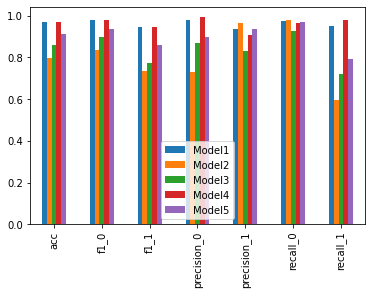

In [53]:
ax = df.plot.bar()

In [54]:
acc = [dict1["accuracy"],dict2["accuracy"],dict3["accuracy"],dict4["accuracy"],dict5["accuracy"]]
f1_0 = [dict1['0']['f1-score'],dict2['0']['f1-score'],dict3['0']['f1-score'],dict4['0']['f1-score'],dict5['0']['f1-score']]
f1_1 = [dict1['1']['f1-score'],dict2['1']['f1-score'],dict3['1']['f1-score'],dict4['1']['f1-score'],dict5['1']['f1-score']]
precision_0 = [dict1['0']['precision'],dict2['0']['precision'],dict3['0']['precision'],dict4['0']['precision'],dict5['0']['precision']]
precision_1 = [dict1['1']['precision'],dict2['1']['precision'],dict3['1']['precision'],dict4['1']['precision'],dict5['1']['precision']]
recall_0 = [dict1['0']['recall'],dict2['0']['recall'],dict3['0']['recall'],dict4['0']['recall'],dict5['0']['recall']]
recall_1 =[dict1['1']['recall'],dict2['1']['recall'],dict3['1']['recall'],dict4['1']['recall'],dict5['1']['recall']]

index = ['Model1', 'Model2','Model3', 'Model4','Model5']
df1 = pd.DataFrame({'acc': acc,
                   'f1_0': f1_0, 'f1_1':f1_1, 'precision_0':precision_0, 'precision_1':precision_1,'recall_0':recall_0,'recall_1':recall_1}, index=index)
df1

,acc,f1_0,f1_1,precision_0,precision_1,recall_0,recall_1
Model1,0.968116,0.977627,0.944538,0.980952,0.936667,0.974324,0.952542
Model2,0.799034,0.838006,0.735369,0.731973,0.963333,0.979964,0.594650
Model3,0.857971,0.896842,0.772093,0.869388,0.830000,0.926087,0.721739
Model4,0.969082,0.978552,0.944637,0.993197,0.910000,0.964333,0.982014
Model5,0.911111,0.935028,0.859327,0.900680,0.936667,0.972100,0.793785


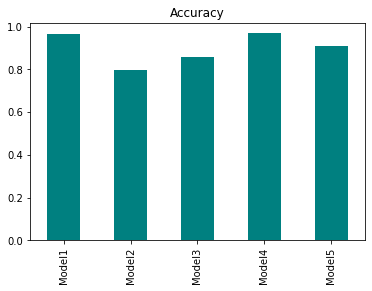

In [55]:
df1['acc'].plot.bar(title = "Accuracy",color="teal")

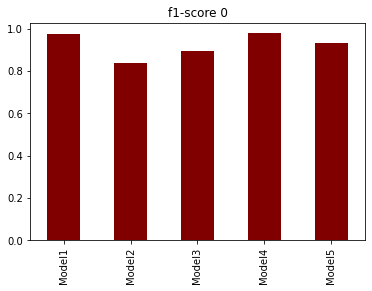

In [56]:
df1['f1_0'].plot.bar(title = "f1-score 0", color = "maroon")

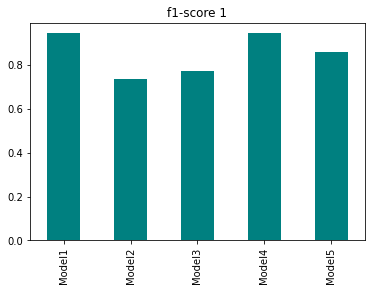

In [57]:
df1['f1_1'].plot.bar(title = "f1-score 1", color = "teal")

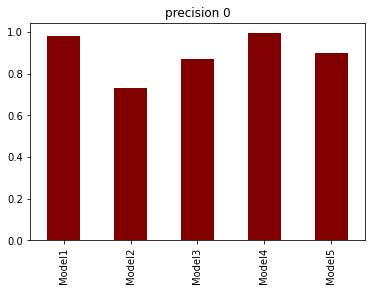

In [58]:
df1['precision_0'].plot.bar(title = "precision 0", color = "maroon")


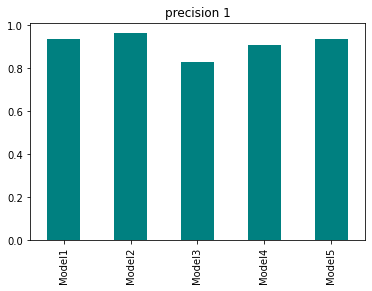

In [59]:
df1['precision_1'].plot.bar(title = "precision 1", color = "teal")

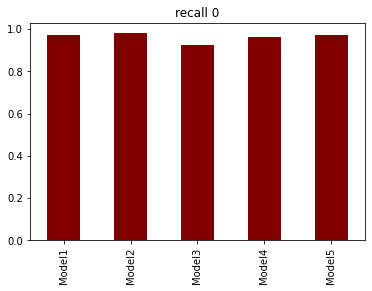

In [60]:
df1['recall_0'].plot.bar(title = "recall 0", color = "maroon")

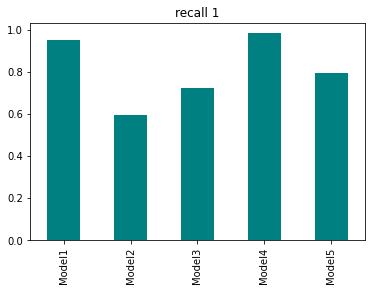

In [61]:
df1['recall_1'].plot.bar(title = "recall 1", color = "teal")

,Model1,Model2,Model3,Model4,Model5
acc,0.968116,0.799034,0.857971,0.969082,0.911111
f1,0.944538,0.735369,0.772093,0.944637,0.859327
precision,0.952542,0.594650,0.721739,0.982014,0.793785
recall,0.936667,0.963333,0.830000,0.910000,0.936667


Text(0, 0.5, 'score')

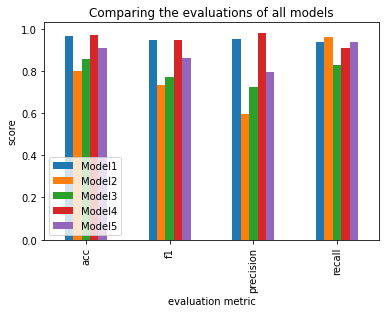

In [98]:
M1 = [a1,f1,p1,r1]
M2 = [a2,f2,p2,r2]
M3 = [a3,f3,p3,r3]
M4 = [a4,f4,p4,r4]
M5 = [a5,f5,p5,r5]


index = ['acc', 'f1', 'precision','recall']
df_1 = pd.DataFrame({'Model1': M1,
                   'Model2': M2, 'Model3':M3, 'Model4':M4, 'Model5':M5}, index=index)
display(df_1)
ax = df_1.plot.bar(title="Comparing the evaluations of all models")
plt.legend(loc='lower left')
ax.set_xlabel("evaluation metric")
ax.set_ylabel("score")

## 4c. Recommended model and reasons

Model 4 is recommended. This is because the model 4 accuracy, f1 for class 0, f1 for class 1, precision for class 0 and recall for class 1 is the highest amongst all the other models. It should also be noted that is has the highest micro average too. Thus model 4 is expected to perform the best when prediciting using the test data set. 

As seen in figure 1, the data set is not balanced since the number of records seen in class 1 is bigger than class 2 for all sets of data (training, validation.testing). Even though model 4 has the highest accuracy, this recommendation is not only based off of that. Model 4 has the highest precision among all the models. This shows that model 4 is able to predict positive records that as positive best. Although model 2 has the best recall score, the best f1-score is also found in model 4. Precision is seen as the measure of quality and recall is seen as the measure of quantity. Precision tells us how much the models returns the more relevant results than the irrelevant ones while recalls tells us how much the model returns most of the relevant results (whether or not irrelevant ones are also returned). If we choose to value quality over quantity, model 4 take precedent over model 2. 


# 5. Evaluation using test set

In [101]:
clean_test_x_join = [" ".join(i) for i in clean_test_x] #turn to string for count_vector 
def report_test(Model):
  predicted = Model.predict(clean_test_x_join)
  return classification_report(predicted,test_y)


print("Model 1")
report1= report_test(Model1)
print(report1)
a1 = get_accuracy(Model1,clean_test_x_join,test_y)
f1 = get_f1_score(Model1,clean_test_x_join,test_y)
p1  = get_precision(Model1,clean_test_x_join,test_y)
r1 = get_recall(Model1,clean_test_x_join,test_y)
print(f"accuracy: {a1}")
print(f"f1 score: {f1}")
print(f"precision: {p1}")
print(f"recall: {r1}")
print("------------------------------------------------------------------------------------------------------")


print("Model 2")
report2 = report_test(Model2)
print(report2)
a2 = get_accuracy(Model2,clean_test_x_join,test_y)
f2 = get_f1_score(Model2,clean_test_x_join,test_y)
p2  = get_precision(Model2,clean_test_x_join,test_y)
r2 = get_recall(Model2,clean_test_x_join,test_y)
print(f"accuracy: {a2}")
print(f"f1 score: {f2}")
print(f"precision: {p2}")
print(f"recall: {r2}")
print("------------------------------------------------------------------------------------------------------")



print("Model 3")
report3= report_test(Model3)
print(report3)
a3 = get_accuracy(Model3,clean_test_x_join,test_y)
f3 = get_f1_score(Model3,clean_test_x_join,test_y)
p3  = get_precision(Model3,clean_test_x_join,test_y)
r3 = get_recall(Model3,clean_test_x_join,test_y)
print(f"accuracy: {a3}")
print(f"f1 score: {f3}")
print(f"precision: {p3}")
print(f"recall: {r3}")
print("------------------------------------------------------------------------------------------------------")


print("Model 4")
report4 = report_test(Model4)
print(report4)
a4 = get_accuracy(Model4,clean_test_x_join,test_y)
f4 = get_f1_score(Model4,clean_test_x_join,test_y)
p4  = get_precision(Model4,clean_test_x_join,test_y)
r4 = get_recall(Model4,clean_test_x_join,test_y)
print(f"accuracy: {a4}")
print(f"f1 score: {f4}")
print(f"precision: {p4}")
print(f"recall: {r4}")
print("------------------------------------------------------------------------------------------------------")


print("Model 5")
report5 = report_test(Model5)
print(report5)
a5 = get_accuracy(Model5,clean_test_x_join,test_y)
f5 = get_f1_score(Model5,clean_test_x_join,test_y)
p5  = get_precision(Model5,clean_test_x_join,test_y)
r5 = get_recall(Model5,clean_test_x_join,test_y)
print(f"accuracy: {a5}")
print(f"f1 score: {f5}")
print(f"precision: {p5}")
print(f"recall: {r5}")
print("------------------------------------------------------------------------------------------------------")


Model 1
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       750
           1       0.92      0.97      0.95       284

    accuracy                           0.97      1034
   macro avg       0.95      0.97      0.96      1034
weighted avg       0.97      0.97      0.97      1034

accuracy: 0.9690522243713733
f1 score: 0.9452054794520549
precision: 0.971830985915493
recall: 0.92
------------------------------------------------------------------------------------------------------
Model 2
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       557
           1       0.96      0.60      0.74       477

    accuracy                           0.81      1034
   macro avg       0.85      0.79      0.79      1034
weighted avg       0.84      0.81      0.80      1034

accuracy: 0.8056092843326886
f1 score: 0.7413127413127413
precision: 0.6037735849056604
recall: 0.96
--------------------------

## 5b. Is recommendation still valid?

,Model1,Model2,Model3,Model4,Model5
acc,0.969052,0.805609,0.871373,0.965184,0.927466
f1,0.945205,0.741313,0.792512,0.937282,0.880383
precision,0.971831,0.603774,0.744868,0.981752,0.844037
recall,0.920000,0.960000,0.846667,0.896667,0.920000


Text(0, 0.5, 'score')

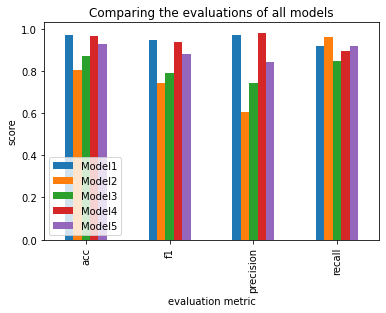

In [102]:
M1 = [a1,f1,p1,r1]
M2 = [a2,f2,p2,r2]
M3 = [a3,f3,p3,r3]
M4 = [a4,f4,p4,r4]
M5 = [a5,f5,p5,r5]


index = ['acc', 'f1', 'precision','recall']
df_2 = pd.DataFrame({'Model1': M1,
                   'Model2': M2, 'Model3':M3, 'Model4':M4, 'Model5':M5}, index=index)
display(df_2)
ax = df_2.plot.bar(title="Comparing the evaluations of all models")
plt.legend(loc='lower left')
ax.set_xlabel("evaluation metric")
ax.set_ylabel("score")

No, our recommendation is not still valid. Model 1 and Model 4 have very close scores in all evaluation metrics however, Model 1 surpasses model 4 with accuracy, f1 score and recall. Model 4 does better only with precision. Since model 1 performs best in 3 out of 4 evaluation metrics, it is the better model. 

# 6. Implementation of 1 more variation to improve performance 

### For our improvement we will use n_grams on features used in model 1 with the aim of improving model 1.

In [103]:
#using a bigram 
pipeline6 = Pipeline([
   ('bow',CountVectorizer(ngram_range=(1,2))),
    ('classifier',MultinomialNB()),
])

In [104]:
Model6 = pipeline6.fit(clean_train_x_join,train_y) #features used in model 1

In [105]:
print("Model 6")
report6=report_test(Model6)
print(report6)
a6 = get_accuracy(Model6,clean_test_x_join,test_y)
f6 = get_f1_score(Model6,clean_test_x_join,test_y)
p6  = get_precision(Model6,clean_test_x_join,test_y)
r6 = get_recall(Model6,clean_test_x_join,test_y)
print(f"accuracy: {a6}")
print(f"f1 score: {f6}")
print(f"precision: {p6}")
print(f"recall: {r6}")
print("------------------------------------------------------------------------------------------------------")

Model 6
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       753
           1       0.92      0.99      0.95       281

    accuracy                           0.97      1034
   macro avg       0.96      0.98      0.97      1034
weighted avg       0.98      0.97      0.97      1034

accuracy: 0.9738878143133463
f1 score: 0.9535283993115319
precision: 0.9857651245551602
recall: 0.9233333333333333
------------------------------------------------------------------------------------------------------


,Model1,Model6
acc,0.969052,0.973888
f1,0.945205,0.953528
precision,0.971831,0.985765
recall,0.920000,0.923333


Text(0, 0.5, 'score')

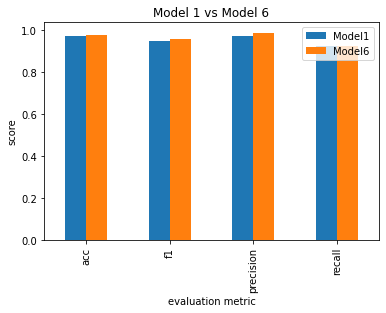

In [108]:
M1 = [a1,f1,p1,r1]
M6 = [a6,f6,p6,r6]


index = ['acc', 'f1', 'precision','recall']
df6 = pd.DataFrame({'Model1': M1,
                   'Model6': M6}, index=index)
display(df6)
ax = df6.plot.bar(title = "Model 1 vs Model 6")
ax.set_xlabel("evaluation metric")
ax.set_ylabel("score")

## Discussion:
Model 6 aimed to improved the best model which is model 1. We utilized n_grams in the count vector in this new variation. This means the corpus will consist of strings of n-words. In this variation, we set the max n to be 2 which results in a bigram. This alteration of our model, improved the model1 (using the test data) on all evaluation metrics. 